In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df = pd.read_csv("./Root_Insurance_data.csv")

With the current $10 flat-bid strategy we collect 1878 clicks, 783 of which result in a policy sold.

This means we spend a total of \\$18,780 on ads with an efficiency of \\$23.98 per customer aquired.

In [4]:
print("total clicks: ",sum(df.click))
print("policies sold: ",sum(df.policies_sold))
print("cost per customer acquired: ${:0.2f}".format(10*sum(df.click)/sum(df.policies_sold)))

total clicks:  1878
policies sold:  783
cost per customer acquired: $23.98


# EDA: What characteristics lead to selling policies?

None of the customer characteristics are overly correlated

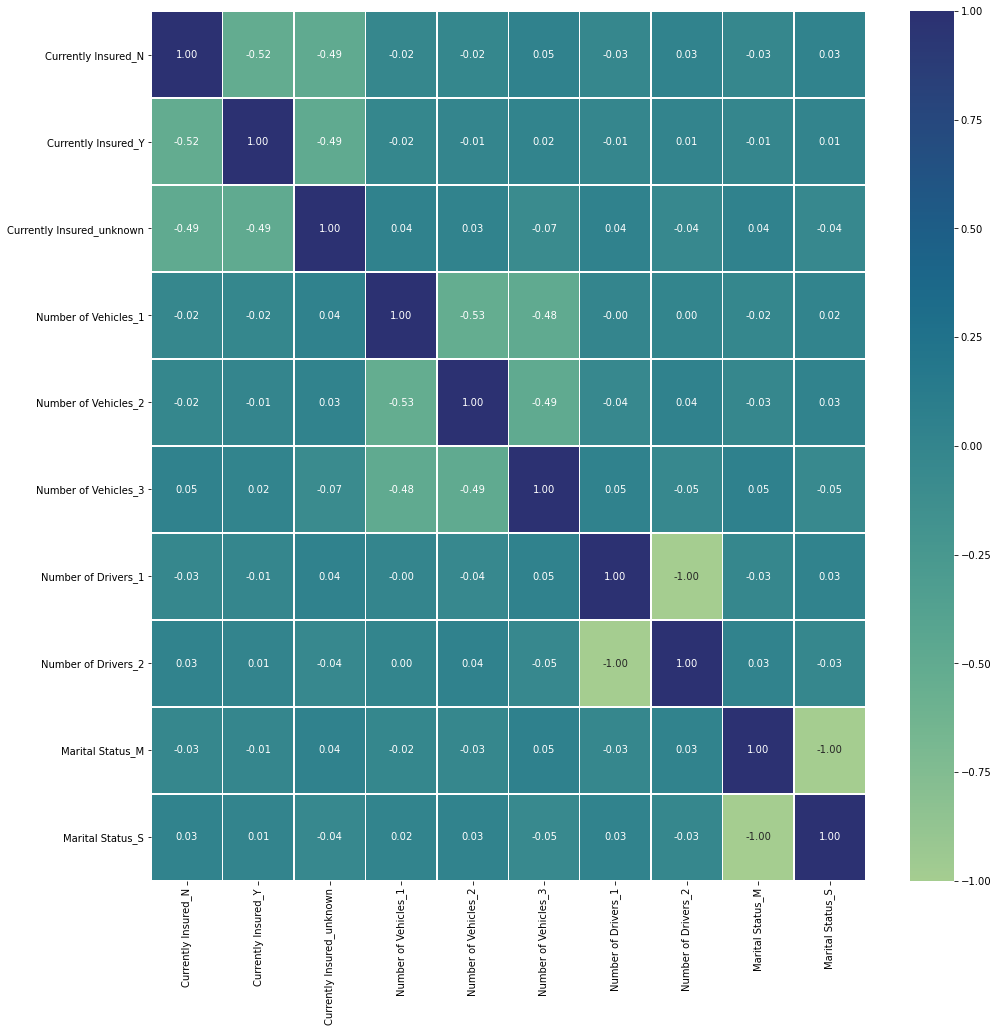

In [5]:
plt.figure(figsize=(16,16))
cmap=sns.color_palette("crest", as_cmap=True)
sns.heatmap(pd.get_dummies(df[["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]],
               columns=["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]).corr(), annot=True, fmt = ".2f", linewidth=0.5, cmap=cmap)
plt.show()

# Which customers are likely to ultimately buy policies?

We'll estimate the probability of customers to buy a policy conditional on an ad click to control for the effects of the placement of our ad in the rankings. The four customer features relevent to our predictions are: insurance status, marital status, number of drivers, and number of vehicles.

There are two potential methods we'll use to estimate the likelihood that a customer buys a policy once they click our ad: 

First, logistic regression which determines a linear regression for the log odds, fitting each independent variable with a coefficient indicating its contribution to the odds of a customer to buy a policy, while controlling for other variables.

Second, a decision tree which can fit any potential non-linear effects of the four categorical variables.

We'll use 5-fold cross validation to determine which model generalizes better to future data by determining which minimizes binary cross entropy.

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

Create dummy variables for data frame

In [7]:
# create dummy variables
xdf = df[["click","policies_sold"]].copy()
xdf[["insured","unknown"]] = pd.get_dummies(df["Currently Insured"])[["Y","unknown"]]
xdf[["cars2","cars3"]] = pd.get_dummies(df["Number of Vehicles"])[[2,3]]
xdf[["drivers2"]] = pd.get_dummies(df["Number of Drivers"])[[1]]
xdf[["married"]] = pd.get_dummies(df["Marital Status"])[["M"]]
# xdf[["rank1","rank2","rank3","rank4","rank5"]] = pd.get_dummies(df["rank"])

create training, testing and validation sets

In [8]:
X[:5]

NameError: name 'X' is not defined

In [ ]:
X = xdf[["insured","unknown","cars2","cars3","drivers2","married"]].loc[xdf.click].to_numpy()
y = xdf["policies_sold"].loc[xdf.click].to_numpy()

kfoldcv = KFold(n_splits=5, shuffle=True, random_state=99)

glm = LogisticRegression()
tree = RandomForestClassifier()

losses_regression = np.zeros(5)
losses_forest = np.zeros(5)

i=0 # track cv index
for train_index, test_index in kfoldcv.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    glm.fit(X_train,y_train)
    tree.fit(X_train,y_train)
    nb.fit(X_train,y_train)
    losses_regression[i] = log_loss(y_test,glm.predict_proba(X_test))
    losses_forest[i] = log_loss(y_test,tree.predict_proba(X_test))
    i+=1
    
print("Mean CV Loss Regression: ",losses_regression.mean())
print("Mean CV Loss Forest: ",losses_forest.mean())

The log loss favors logistic regression. We'll fit logistic regression to the data set and use this to generate pobability estimates for different classes of customers

In [ ]:
import statsmodels.api as sm

In [ ]:
glm = sm.Logit(xdf["policies_sold"].loc[xdf.click],
    sm.add_constant(xdf[["insured","unknown","cars2","cars3","drivers2","married"]].loc[xdf.click])).fit()

In [ ]:
print(glm.summary())

Marital status is not statistically significant, nor is unknown current insurance status, so we'll omit these variables when we fit the probabilities. 

In [ ]:
glm = sm.Logit(xdf["policies_sold"].loc[xdf.click],
    sm.add_constant(xdf[["insured","cars2","cars3","drivers2"]].loc[xdf.click])).fit()

In [ ]:
print(glm.summary())

From the logistic regression, we see that customers who are already insured are much less likely to buy a policy. Additionally, having more than one vehicle is negatively associated with buying a policy. Customers with two drivers are more likely to end up purchasing a policy.

# Disribution of Rankings for Different Customers

One clear trend in the data is that the distribution of rankings for the current bid strategy is different for different types of customers. 

This indicates that we may may be overbidding or underbidding other insurers' bids for different customers. One way to increase the efficiency of ad bids is to adjust our bids higher or lower based on how much other insurers' are willing to bid for specific groups of customers.

Let's first consider the distribution of rankings among all customers. We have at least 1500 data points for each rank, and there's no clear trend for the distribution of rankings among all customers.

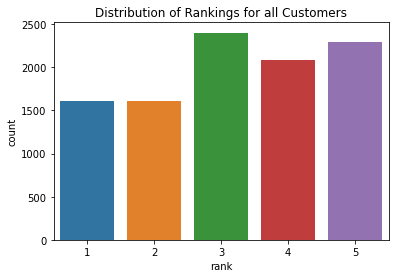

In [10]:
# barplot count of occurences of each rank
sns.countplot(x="rank",data=df)
plt.title("Distribution of Rankings for all Customers")
plt.show()

This is not the case when we restrict to different classes of customers. 

For example, when we consider customers with two or fewer vehicles whose insurance status is unknown, our ad always places in the top 3 rankings, and appears most frequently in rank 1, suggesting that we are overbidding the market for such customers.

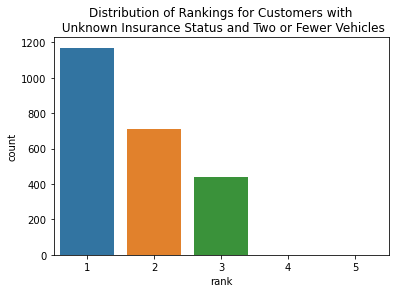

In [11]:
sns.countplot(x="rank", data = df.loc[ (df["Currently Insured"]=="unknown") & (df["Number of Vehicles"] <= 2)],
             order = [1,2,3,4,5])
plt.title("Distribution of Rankings for Customers with\n Unknown Insurance Status and Two or Fewer Vehicles")
plt.show()

On the other hand, when we consider customers with known insurance status and two or more vehicles, we find that our ads are consistently ranked lower, so that we typically rank in the bottom 3, and most often rank last. It's clear that other insurers are bidding more for these customers and our ads are being outbid.

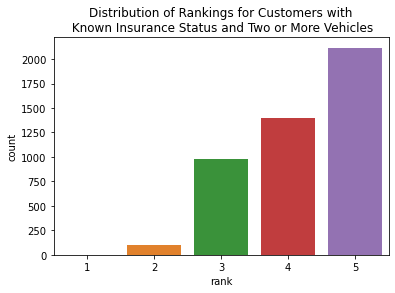

In [12]:
sns.countplot(x="rank", data = df.loc[ (df["Currently Insured"]!="unknown") & (df["Number of Vehicles"] >= 2)],
             order=[1,2,3,4,5])
plt.title("Distribution of Rankings for Customers with\n Known Insurance Status and Two or More Vehicles")
plt.show()

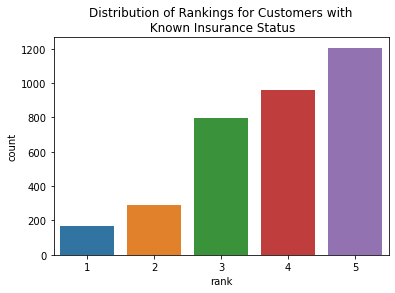

In [17]:
sns.countplot(x="rank", data = df.loc[ (df["Currently Insured"]=="Y") ],
             order=[1,2,3,4,5])
plt.title("Distribution of Rankings for Customers with\n Known Insurance Status")
plt.show()

Next, if we consider customers with one vehicle and known insurance status, our bids most freqiuently rank 3rd, and less frequently 1st or 5th, which indicates our \\$10 bid is likely comprable to other insurers' bids.

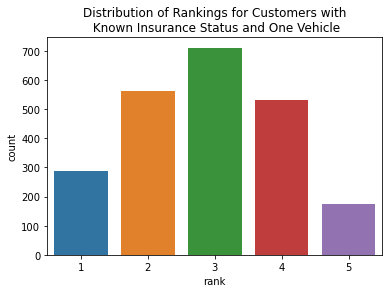

In [88]:
sns.countplot(x="rank", data = df.loc[(df["Currently Insured"]!="unknown")&(df["Number of Vehicles"] == 1)] )
plt.title("Distribution of Rankings for Customers with\n Known Insurance Status and only One Vehicle")
plt.show()

# Estimating Click-thru Rate by Rank

Next, we want to understand the relationship between our ad's ranking, and the number of clicks it aquires. This is important for developing an efficient bid strategy because we need to understand how listing higher ad rankings translates into more clicks, and ultimately more policies sold.

We find that cluck-thru rates are the highest when our ad ranks first (53% probability for customer to click), and the click-thru rate drops quickly as the rank increases until the bottom rank (2% probability to get a click)

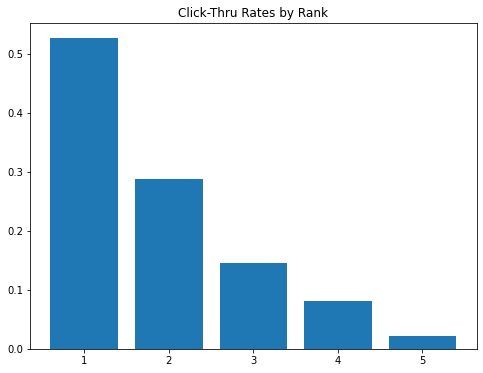

In [32]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5],df.groupby("rank").mean().click)
plt.title("Click-Thru Rates by Rank")
plt.show()

Let's see if controlling for customer characteristics (insured status, marital status, number of vehicles, number of drivers) affects click thru rates by rank 

In [34]:
glm_click = sm.Logit(xdf["click"],
    sm.add_constant(xdf[["insured","unknown","married","cars2","cars3","drivers2",
                         "rank1","rank2","rank3","rank4"]])).fit()
print(glm_click.summary())

Optimization terminated successfully.
         Current function value: 0.388893
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.1949
Time:                        12:58:26   Log-Likelihood:                -3888.9
converged:                       True   LL-Null:                       -4830.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7038      0.168    -22.000      0.000      -4.034      -3.374
insured        0.1053      0.

Most customer characteristics are not statistically significant, except for marital status, and customers with two vehicles. When the regression is run with just these variables we see that they are both negatively associated with clicking an ad given its rank.

In [36]:
glm_click = sm.Logit(xdf["click"],
    sm.add_constant(xdf[["married","cars2","rank1","rank2","rank3","rank4"]])).fit()
print(glm_click.summary())

Optimization terminated successfully.
         Current function value: 0.389023
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  click   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.1946
Time:                        12:59:30   Log-Likelihood:                -3890.2
converged:                       True   LL-Null:                       -4830.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6610      0.149    -24.538      0.000      -3.953      -3.369
married       -0.1587      0.

Let's examine the distribution of click-rates for married customers. We see that the click rates are similar to the population as a whole, but also that our ads appeared less frequently in ranks 1 and 2 for married customers.

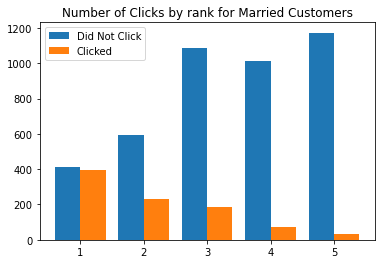

In [94]:
plt.figure(figsize=(6,4))
plt.hist( [df["rank"].loc[df["Marital Status"]=="M"].loc[df["click"]==0],
           df["rank"].loc[df["Marital Status"]=="M"].loc[df["click"]==1]],
         bins=[0.5,1.5,2.5,3.5,4.5,5.5], stacked=False, histtype="bar", label=["Did Not Click","Clicked"])
plt.title("Number of Clicks by rank for Married Customers")
plt.legend()
plt.show()

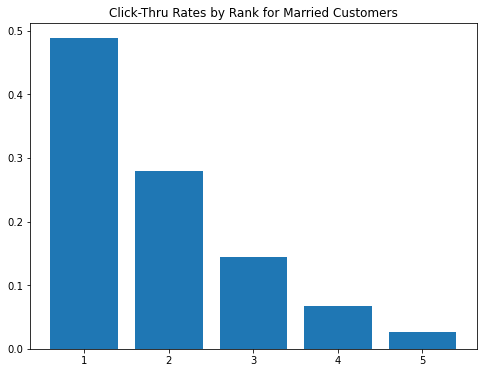

In [93]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5],df.loc[df["Marital Status"]=="M"].groupby("rank").mean().click)
plt.title("Click-Thru Rates by Rank for Married Customers")
plt.show()

Smiliarly, we can examine the click-thru rates by rank for all customers with two vehicles. We see there is an imbalance in the ranks of our advertisements: Rank 5 is overrepresented, while ranks 1 and 2 are underrepresented.

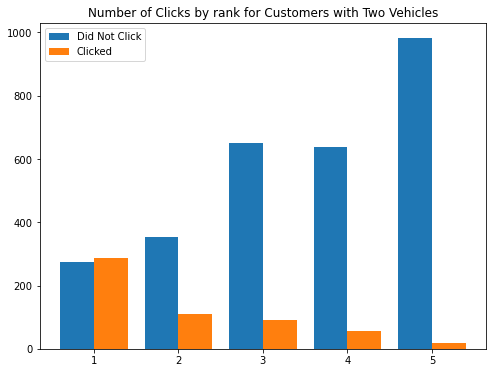

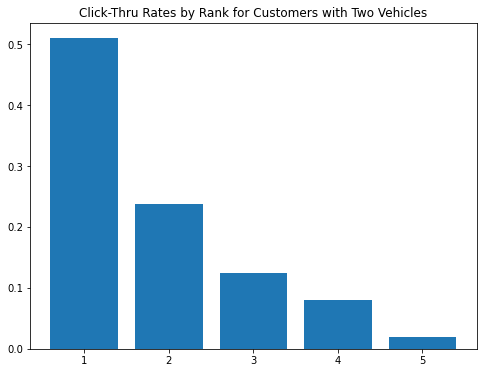

In [78]:
plt.figure(figsize=(8,6))
plt.hist( [df["rank"].loc[df["Number of Vehicles"]==2].loc[df["click"]==0],
           df["rank"].loc[df["Number of Vehicles"]==2].loc[df["click"]==1]],
         bins=[0.5,1.5,2.5,3.5,4.5,5.5], stacked=False, histtype="bar", label=["Did Not Click","Clicked"])
plt.title("Number of Clicks by rank for Customers with Two Vehicles")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5],df.loc[df["Number of Vehicles"]==2].groupby("rank").mean().click)
plt.title("Click-Thru Rates by Rank for Customers with Two Vehicles")
plt.show()

# Modeling Click-Thru Rates by Rank

Overall it seems that click-thru rates by rank are largely independent of customer attributes; all customers tend to click ads at each ranking at similar rates.

So in terms of modeling, we'll use the observed aggregate click rates for each rank, $$ \theta_r = \mathbb P( \mathrm{click} | \mathrm{rank}=r),$$
and take these to be the same for all classes of customers.

In [99]:
df.groupby("rank").mean().click

rank
1    0.526381
2    0.287313
3    0.146189
4    0.080421
5    0.021388
Name: click, dtype: float64